In [142]:
import os
import re
import sys
import math
import tqdm
import torch
import time
import datetime
import numpy as np
import pandas as pd
from typing import Union
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel 
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

def plot_log_file(metrics_csv, metrics_img):
    df = pd.read_csv(metrics_csv)

    # Find the epoch corresponding to the minimum value of 'train_rmse'
    epoch_min_train_rmse = df.loc[df["train_rmse"].idxmin(), "epoch"]
    min_train_rmse = df["train_rmse"].min()
    print(f"Epoch: {epoch_min_train_rmse}, Min. Train RMSE: {min_train_rmse}")

    # Find the epoch corresponding to the minimum value of 'test_rmse'
    epoch_min_test_rmse = df.loc[df["test_rmse"].idxmin(), "epoch"]
    min_test_rmse = df["test_rmse"].min()
    print(f"Epoch: {epoch_min_test_rmse}, Min. Test RMSE: {min_test_rmse}")

    # Plotting
    sns.set_theme(style="darkgrid")
    fontsize = 28
    plt.subplots(figsize=(16, 9))
    plt.plot(df['epoch'], df['test_rmse'], label='Test RMSE', color='tab:blue', linewidth=3)
    plt.plot(df['epoch'], df['train_rmse'], label='Train RMSE', color='tab:orange', linewidth=3)
    plt.xlabel('Epochs', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.xlim(-200, 5200)
    plt.ylabel('Loss', fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylim(-0.05, 1.4)
    plt.legend(loc='upper right', fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(metrics_img, format='pdf')

def plot_all_log_file(metrics_csv, metrics_img):
    df = pd.read_csv(metrics_csv)

    # Find the epoch corresponding to the minimum value of 'Train Binding RMSE'
    epoch_min_train_rmse = df.loc[df["Train Binding RMSE"].idxmin(), "Epoch"]
    min_train_rmse = df["Train Binding RMSE"].min()
    print(f"Epoch: {epoch_min_train_rmse}, Min. Train Binding RMSE: {min_train_rmse}")

    # Find the epoch corresponding to the minimum value of 'Test Binding RMSE'
    epoch_min_test_rmse = df.loc[df["Test Binding RMSE"].idxmin(), "Epoch"]
    min_test_rmse = df["Test Binding RMSE"].min()
    print(f"Epoch: {epoch_min_test_rmse}, Min. Test Binding RMSE: {min_test_rmse}\n")

    # Find the epoch corresponding to the minimum value of 'Train Expression RMSE'
    epoch_min_train_rmse = df.loc[df["Train Expression RMSE"].idxmin(), "Epoch"]
    min_train_rmse = df["Train Expression RMSE"].min()
    print(f"Epoch: {epoch_min_train_rmse}, Min. Train Expression RMSE: {min_train_rmse}")

    # Find the epoch corresponding to the minimum value of 'Test Expression RMSE'
    epoch_min_test_rmse = df.loc[df["Test Expression RMSE"].idxmin(), "Epoch"]
    min_test_rmse = df["Test Expression RMSE"].min()
    print(f"Epoch: {epoch_min_test_rmse}, Min. Expression Test RMSE: {min_test_rmse}\n")

    # Find the epoch corresponding to the minimum value of 'Train RMSE'
    epoch_min_train_rmse = df.loc[df["Train RMSE"].idxmin(), "Epoch"]
    min_train_rmse = df["Train RMSE"].min()
    print(f"Epoch: {epoch_min_train_rmse}, Min. Train RMSE: {min_train_rmse}")

    # Find the epoch corresponding to the minimum value of 'Test RMSE'
    epoch_min_test_rmse = df.loc[df["Test RMSE"].idxmin(), "Epoch"]
    min_test_rmse = df["Test RMSE"].min()
    print(f"Epoch: {epoch_min_test_rmse}, Min. Test RMSE: {min_test_rmse}\n")

    # Plotting
    sns.set_theme(style="darkgrid")
    fontsize = 28
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 18))  # 2 rows, 1 column

    # Plot 1: Training Metrics (binding, expression, combined RMSE)
    ax1.plot(df['Epoch'], df['Train Binding RMSE'], label='Train Binding RMSE', color='tab:blue', linewidth=3)
    ax1.plot(df['Epoch'], df['Train Expression RMSE'], label='Train Expression RMSE', color='tab:green', linewidth=3)
    ax1.plot(df['Epoch'], df['Train RMSE'], label='Train RMSE (Combined)', color='tab:orange', linewidth=3)
    ax1.set_xlabel('Epochs', fontsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize)
    ax1.set_xlim(-200, 5200)
    ax1.set_ylabel('Loss', fontsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.set_ylim(-0.05, 1.4)
    ax1.legend(loc='upper right', fontsize=fontsize)
    ax1.set_title('Training Metrics', fontsize=fontsize)

    # Plot 2: Testing Metrics (binding, expression, combined RMSE)
    ax2.plot(df['Epoch'], df['Test Binding RMSE'], label='Test Binding RMSE', color='tab:blue', linewidth=3)
    ax2.plot(df['Epoch'], df['Test Expression RMSE'], label='Test Expression RMSE', color='tab:green', linewidth=3)
    ax2.plot(df['Epoch'], df['Test RMSE'], label='Test RMSE (Combined)', color='tab:orange', linewidth=3)
    ax2.set_xlabel('Epochs', fontsize=fontsize)
    ax2.tick_params(axis='x', labelsize=fontsize)
    ax2.set_xlim(-200, 5200)
    ax2.set_ylabel('Loss', fontsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)
    ax2.set_ylim(-0.05, 1.4)
    ax2.legend(loc='upper right', fontsize=fontsize)
    ax2.set_title('Testing Metrics', fontsize=fontsize)

    plt.tight_layout()
    plt.savefig(metrics_img, format='pdf')

## OLDER DMS DATA
Here we will have several plots based on training with the old DMS data for 5000 epochs. We look at both expression and binding DMS data. No missing values per ID are included in each individual dataset; however, combining the datasets shows that some IDs may have missing binding but not expression values (and vice versa). This is cleaned up in the combined dataset, which is why there are less entries.

There are 2 different datasets for the older DMS data:
- Binding and expression data separated
    - Binding: 105,525 entries
    - Expression: 116,257 entries
- Binding and expression data combined into single dataset by ID
    - Binding: 102,723 entries
    - Expression: 102,723 entries

I will show the results of training with these datasets in this order:
1) Original training of the older DMS data 
    - binding/expression trained separately
2) Combined training of the older DMS data 
    - binding/expression trained together

Epoch: 5000, Min. Train RMSE: 0.0049974025007019
Epoch: 63, Min. Test RMSE: 0.5565162630343344


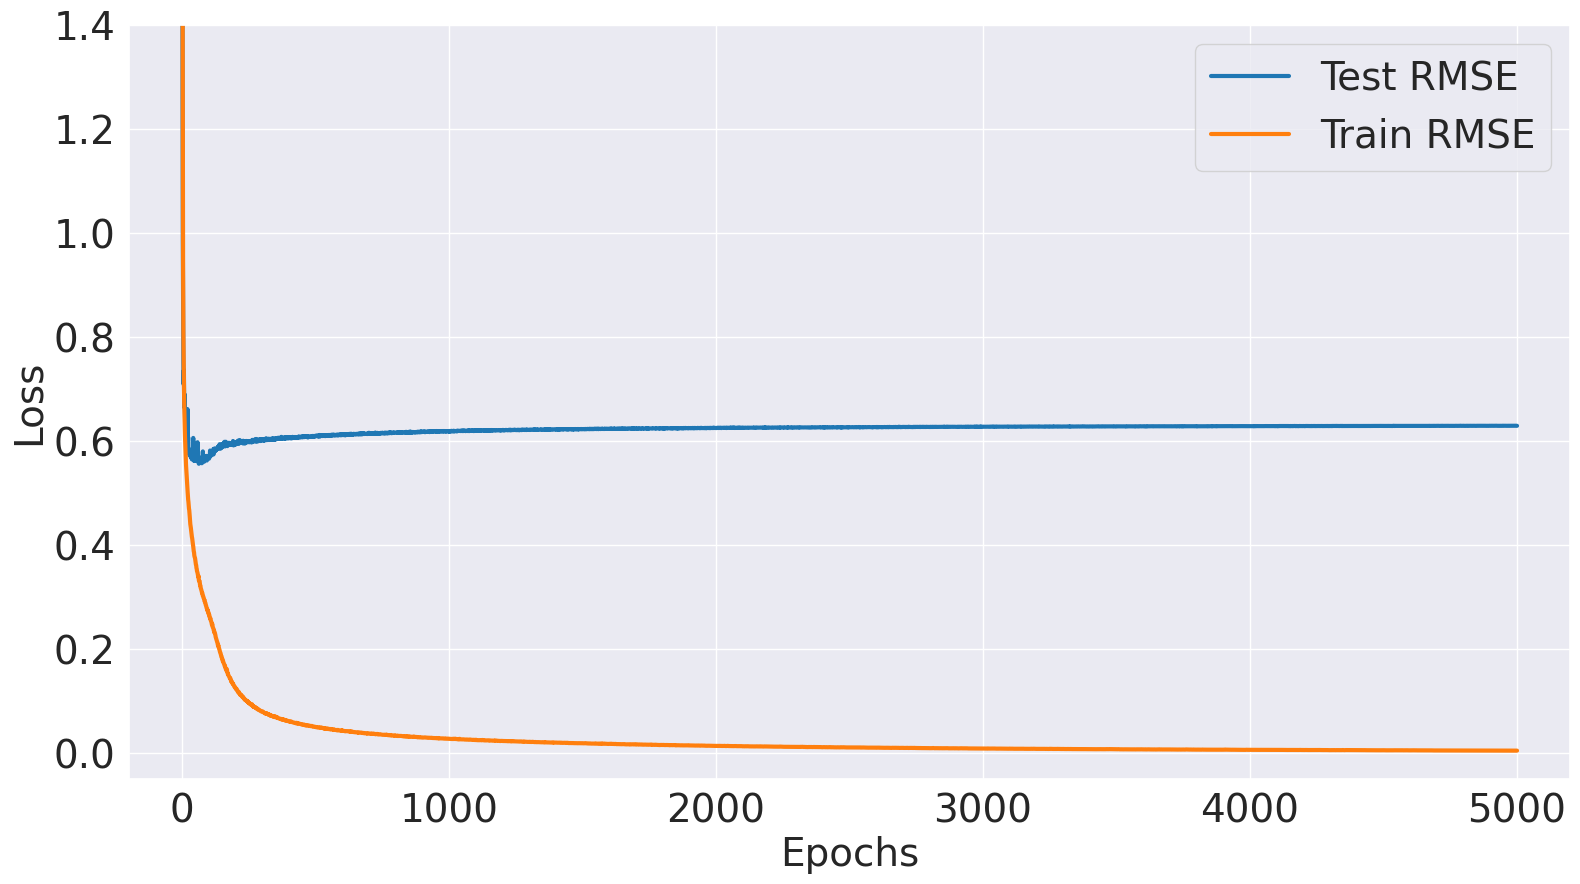

In [143]:
# Older DMS data, training separate
esm_binding_csv = "../results/run_results/esm-blstm/esm-blstm-esm_dms_binding-2023-12-12_17-02/esm-blstm-esm_dms_binding-2023-12-12_17-02_train_84420_test_21105_metrics_per.csv"
esm_binding_pdf = "../results/run_results/esm-blstm/esm-blstm-esm_dms_binding-2023-12-12_17-02/esm-blstm-esm_dms_binding-2023-12-12_17-02_train_84420_test_21105_metrics_per.pdf"
plot_log_file(esm_binding_csv, esm_binding_pdf)

Epoch: 4960, Min. Train RMSE: 0.000549603054318
Epoch: 42, Min. Test RMSE: 0.4569100085850099


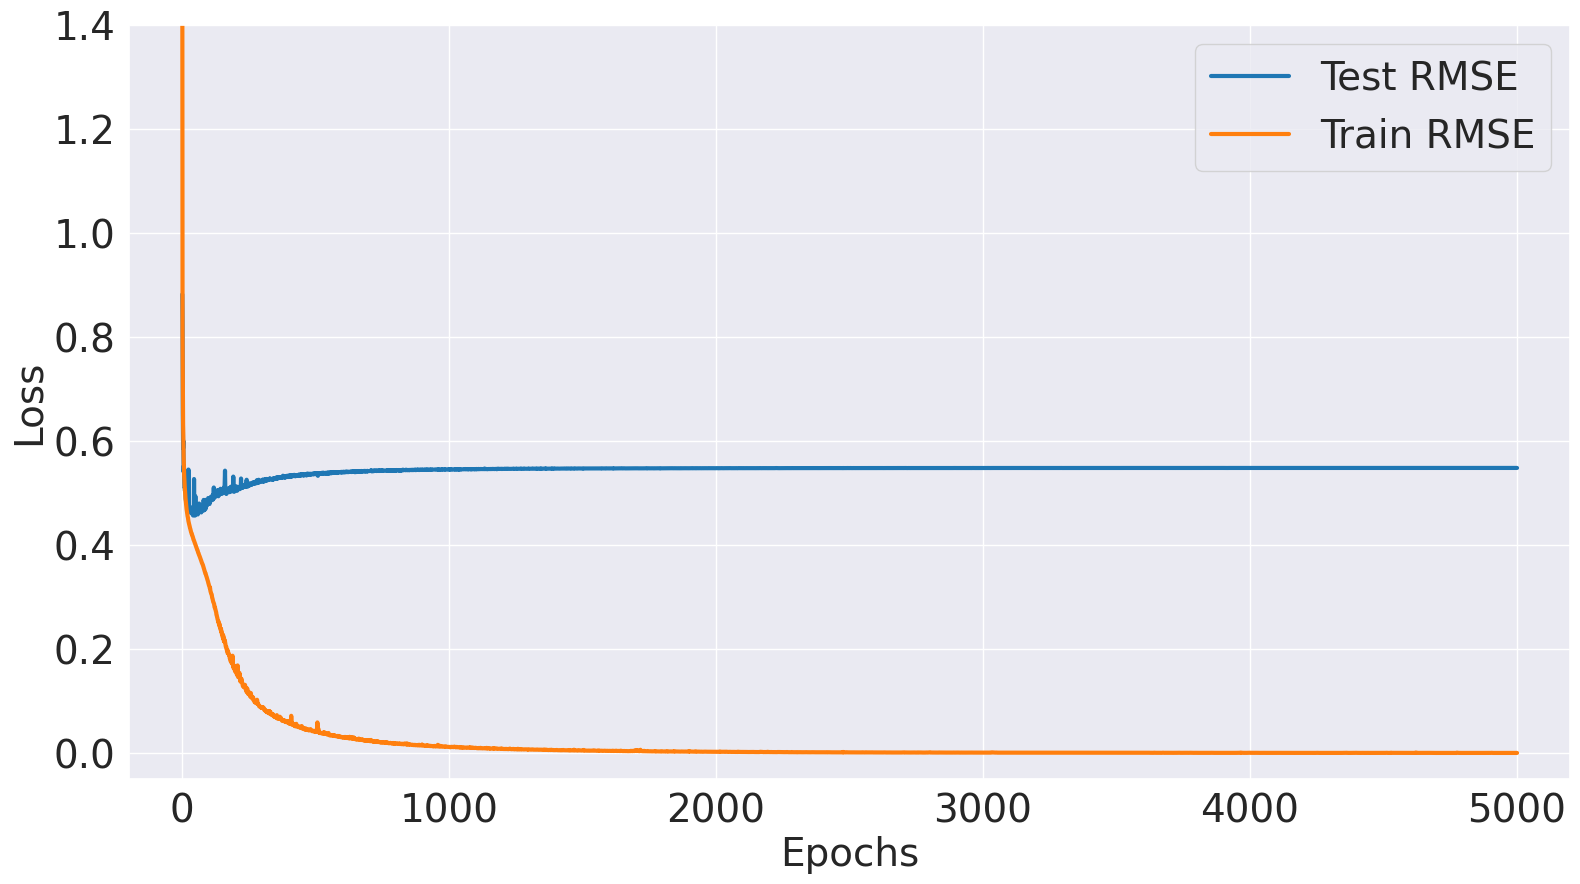

In [144]:
# Older DMS data, training separate
esm_expression_csv = "../results/run_results/esm-blstm/esm-blstm-esm_dms_expression-2023-12-12_16-58/esm-blstm-esm_dms_expression-2023-12-12_16-58_train_93005_test_23252_metrics_per.csv"
esm_expression_pdf = "../results/run_results/esm-blstm/esm-blstm-esm_dms_expression-2023-12-12_16-58/esm-blstm-esm_dms_expression-2023-12-12_16-58_train_93005_test_23252_metrics_per.pdf"
plot_log_file(esm_expression_csv, esm_expression_pdf)

Epoch: 3701, Min. Train Binding RMSE: 0.0078285149210204
Epoch: 41, Min. Test Binding RMSE: 0.5855119870448955

Epoch: 3725, Min. Train Expression RMSE: 0.0088077304540921
Epoch: 64, Min. Expression Test RMSE: 0.42466033456465

Epoch: 3725, Min. Train RMSE: 0.0118236999633768
Epoch: 39, Min. Test RMSE: 0.7264128106598082



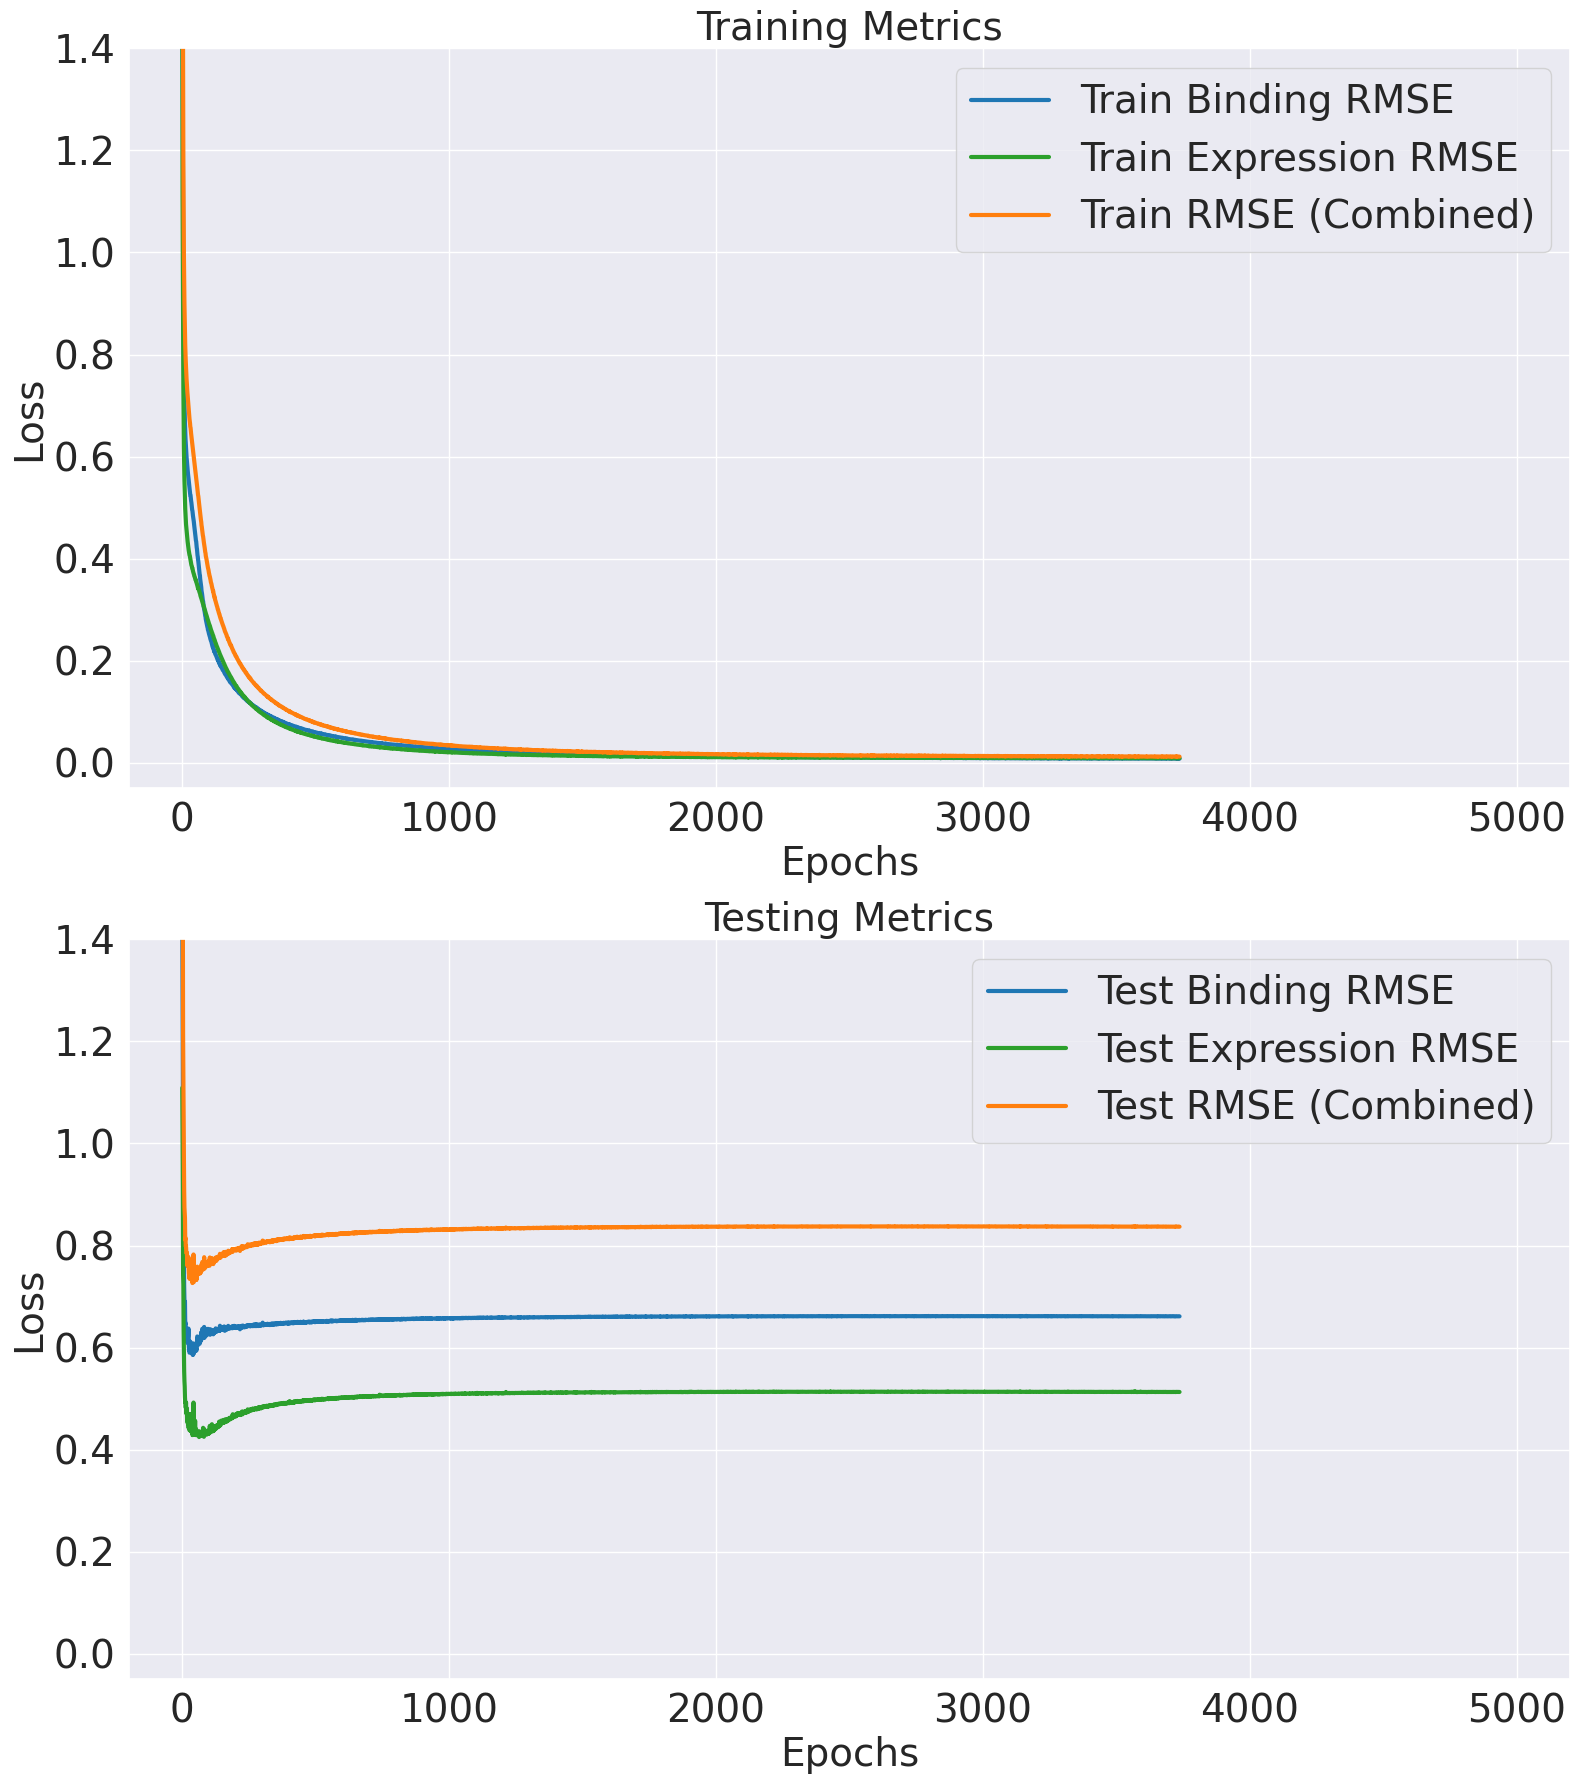

In [153]:
# Older DMS data, training together
esm_csv = "./run_results/esm-blstm/esm_blstm-dms_combined_OLD_DMS_DATA_COMBINED-2024-09-01_23-08/esm_blstm-dms_combined_OLD_DMS_DATA-train_77799_test_19450_metrics.csv"
esm_pdf = "./run_results/esm-blstm/esm_blstm-dms_combined_OLD_DMS_DATA_COMBINED-2024-09-01_23-08/esm_blstm-dms_combined_OLD_DMS_DATA-train_77799_test_19450_metrics.pdf"
plot_all_log_file(esm_csv, esm_pdf)

--- 
## Newer DMS data
Here we will have several plots based on training with the new DMS data for 5000 epochs. We look at both expression and binding DMS data. No missing values per ID are included in each individual dataset; however, combining the datasets shows that some IDs may have missing binding but not expression values (and vice versa). This is cleaned up in the combined dataset, which is why there are less entries.

There are 2 different datasets for the newer DMS data:
- Binding and expression data separated
    - Binding: 98,497 entries
    - Expression: 104,101 entries
- Binding and expression data combined into single dataset by ID
    - Binding: 97,249 entries
    - Expression: 97,249 entries

I will show the results of training with these datasets in this order:
1) Training of the newer DMS data, weights from separate
    - weights from the original training of the older DMS data loaded
    - binding/expression trained separately
2) Combined training of the newer DMS data, weights from separate
    - weights from the original training of the older DMS data loaded into each head
    - binding/expression trained separately
3) Combined training of the newer DMS data, weights from combined
    - weights from the newer combined training of the older DMS data loaded
    - binding/expression trained together

In [147]:
def plot_log_file(metrics_csv, metrics_img):
    df = pd.read_csv(metrics_csv)

    # Find the epoch corresponding to the minimum value of 'Train RMSE'
    epoch_min_train_rmse = df.loc[df["Train RMSE"].idxmin(), "Epoch"]
    min_train_rmse = df["Train RMSE"].min()
    print(f"Epoch: {epoch_min_train_rmse}, Min. Train RMSE: {min_train_rmse}")

    # Find the epoch corresponding to the minimum value of 'Test RMSE'
    epoch_min_test_rmse = df.loc[df["Test RMSE"].idxmin(), "Epoch"]
    min_test_rmse = df["Test RMSE"].min()
    print(f"Epoch: {epoch_min_test_rmse}, Min. Test RMSE: {min_test_rmse}")

    # Plotting
    sns.set_theme(style="darkgrid")
    fontsize = 28
    plt.subplots(figsize=(16, 9))
    plt.plot(df['Epoch'], df['Test RMSE'], label='Test RMSE', color='tab:blue', linewidth=3)
    plt.plot(df['Epoch'], df['Train RMSE'], label='Train RMSE', color='tab:orange', linewidth=3)
    plt.xlabel('Epochs', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.xlim(-200, 5200)
    plt.ylabel('Loss', fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylim(-0.05, 1.4)
    plt.legend(loc='upper right', fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(metrics_img, format='pdf')

Epoch: 4709, Min. Train RMSE: 0.0117169365280347
Epoch: 18, Min. Test RMSE: 0.6099822256579938


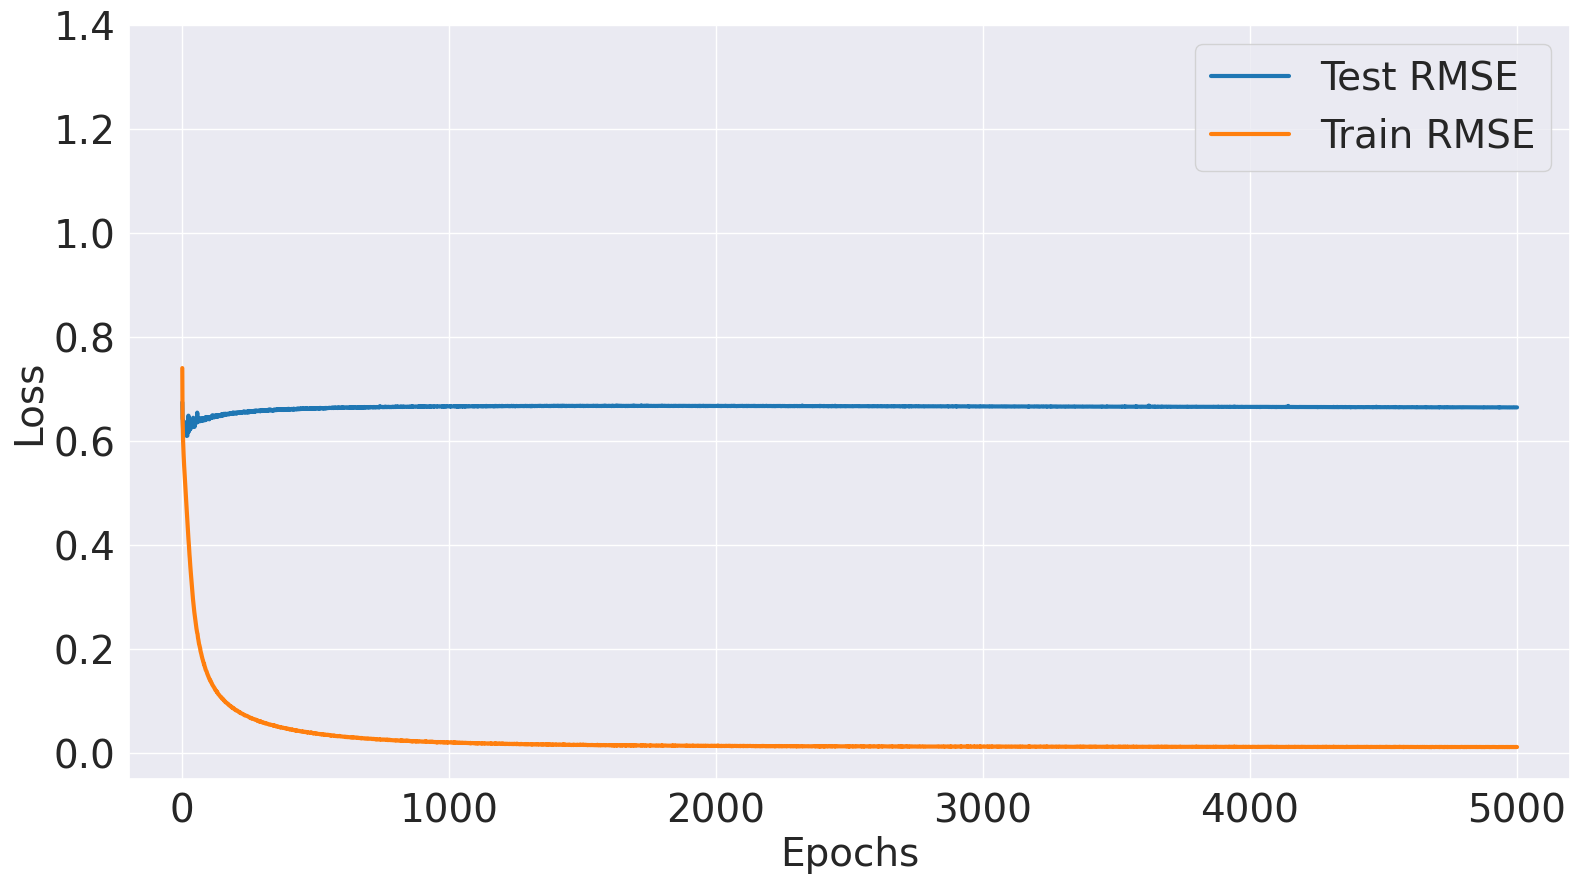

In [154]:
# Newer DMS data, separate older DMS data weights, training separate
esm_binding_csv = "./run_results/esm-blstm/esm_blstm-dms_binding_OLD_DMS_DATA_SEPARATE-2024-08-20_15-24/esm_blstm-dms_binding-train_78797_test_19700_metrics.csv"
esm_binding_pdf = "./run_results/esm-blstm/esm_blstm-dms_binding_OLD_DMS_DATA_SEPARATE-2024-08-20_15-24/esm_blstm-dms_binding-train_78797_test_19700_metrics.pdf"
plot_log_file(esm_binding_csv, esm_binding_pdf)

Epoch: 4092, Min. Train RMSE: 0.0070949296815935
Epoch: 20, Min. Test RMSE: 0.4513008093436276


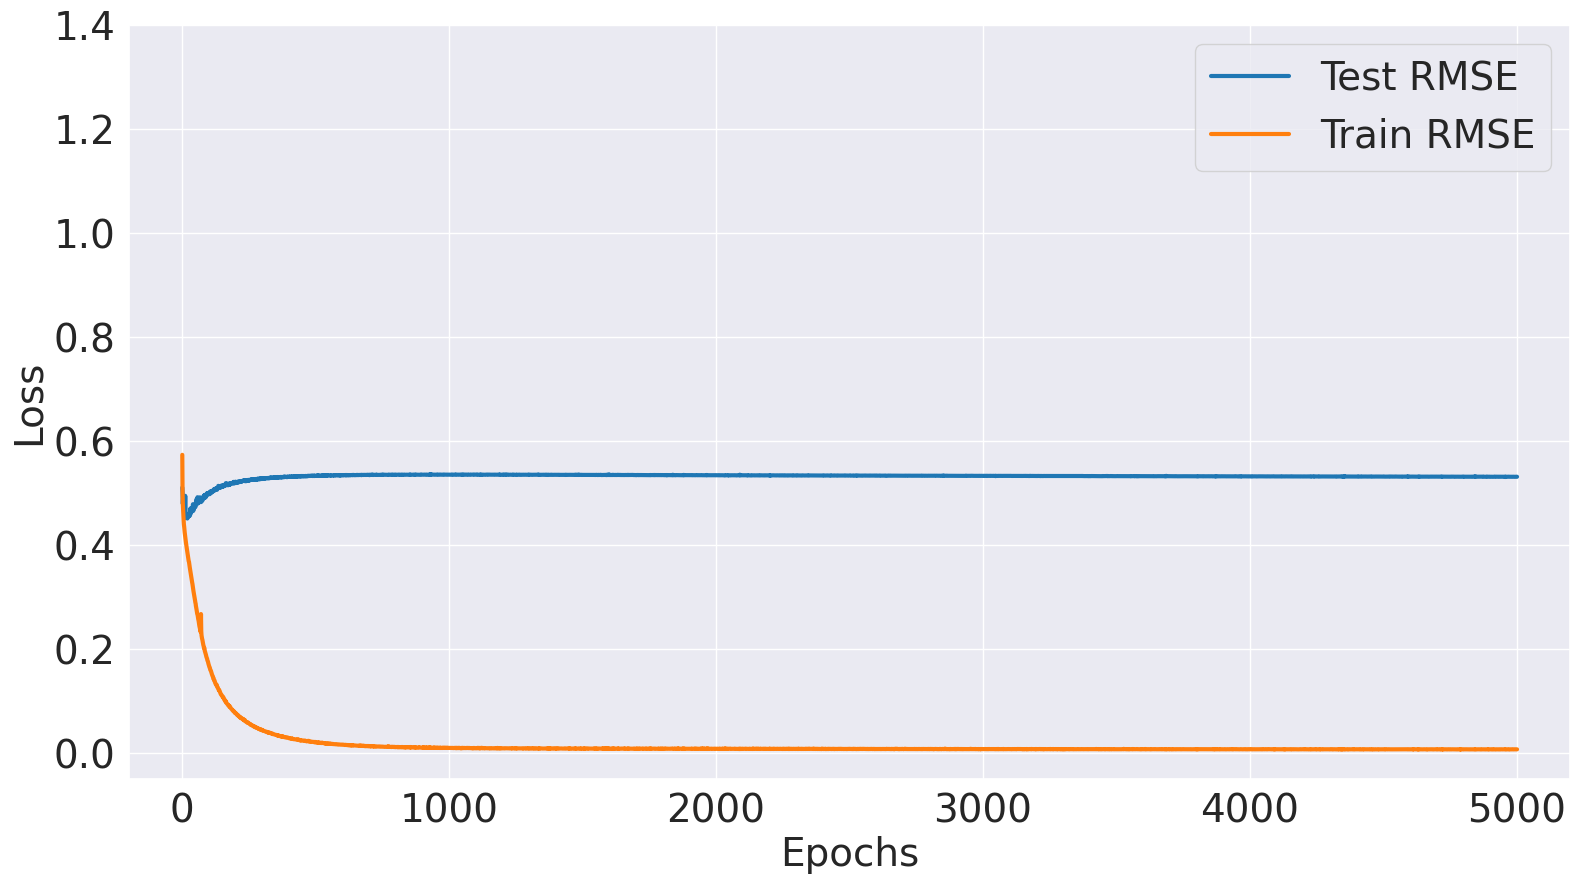

In [155]:
# Newer DMS data, separate older DMS data weights, training separate
esm_expression_csv = "./run_results/esm-blstm/esm_blstm-dms_expression_OLD_DMS_DATA_SEPARATE-2024-08-20_15-27/esm_blstm-dms_expression-train_83280_test_20821_metrics.csv"
esm_expression_pdf = "./run_results/esm-blstm/esm_blstm-dms_expression_OLD_DMS_DATA_SEPARATE-2024-08-20_15-27/esm_blstm-dms_expression-train_83280_test_20821_metrics.pdf"
plot_log_file(esm_expression_csv, esm_expression_pdf)

In [ ]:
# Newer DMS data, separate older DMS data weights, training combined
esm_csv = "."
esm_pdf = "."
plot_all_log_file(esm_csv, esm_pdf)

Cannot run below, need combined older weights run

In [ ]:
# Newer DMS data, combined older DMS data weights, training combined
esm_csv = "."
esm_pdf = "."
plot_all_log_file(esm_csv, esm_pdf)